# 載入套件

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance 
from xgboost import XGBRegressor

# 下載 & 讀取資料集

##### 已預先下載

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d wkirgsn/electric-motor-temperature
! unzip electric-motor-temperature.zip

 94% 109M/117M [00:02<00:00, 37.4MB/s] 
100% 117M/117M [00:02<00:00, 52.7MB/s]
Archive:  electric-motor-temperature.zip
  inflating: measures_v2.csv         


In [19]:
dataset = pd.read_csv('measures_v2.csv')
dataset

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,1.871008e-01,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,2.454175e-01,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,1.766153e-01,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,2.383027e-01,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,2.081967e-01,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.152128,30.721298,45.274497,0.791801,41.934347,0.000380,-2.000169,1.097528,62.147780,38.653720,23.989078,-8.116730e-60,71
1330812,-2.258684,30.721306,45.239017,0.778900,41.868923,0.002985,-2.000499,1.097569,62.142646,38.656328,23.970700,-5.815891e-60,71
1330813,-2.130312,30.721312,45.211576,0.804914,41.804819,0.002301,-1.999268,1.098765,62.138387,38.650923,23.977234,-4.167268e-60,71
1330814,-2.268498,30.721316,45.193508,0.763091,41.762220,0.005662,-2.000999,1.095696,62.133422,38.655686,24.001421,-2.985978e-60,71


# 資料前處理



In [20]:
X = dataset.copy().drop(columns = ['profile_id', 'pm'])
y = dataset.pm
colnames = X.columns
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.6)

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)
train_x = pd.DataFrame(train_x, columns = colnames)
test_x = pd.DataFrame(test_x, columns = colnames)

# 最佳化 (Grid Search)

##### 已預先找到最佳超參數

In [4]:
parameter_1 = {
    'alpha': [0.01, 0.1, 1, 10, 100]
    }
clf = GridSearchCV(Ridge(), parameter_1, scoring = 'r2', cv = 3)
clf.fit(train_x, train_y)
best_index_1 = np.argmin(clf.cv_results_['rank_test_score'])
best_param_1 = clf.cv_results_['params'][best_index_1]

parameter_2 = {
    'learning_rate': [0.3, 0.5, 0.7],
    'max_depth': [4, 8],
    'subsample': [0.75],
    'alpha': [0.1]
    }
clf = GridSearchCV(XGBRegressor(), parameter_2, scoring = 'neg_mean_squared_error', cv = 3)
clf.fit(train_x, train_y)
best_index_2 = np.argmin(clf.cv_results_['rank_test_score'])
best_param_2 = clf.cv_results_['params'][best_index_2]
pd.DataFrame(clf.cv_results_)

[15:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_learning_rate,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,45.456222,0.280240,0.693232,0.078384,0.1,0.3,4,0.75,"{'alpha': 0.1, 'learning_rate': 0.3, 'max_dept...",-17.038336,-21.419394,-16.207423,-18.221718,2.286402,6
1,102.263097,0.212384,1.821701,0.025301,0.1,0.3,8,0.75,"{'alpha': 0.1, 'learning_rate': 0.3, 'max_dept...",-3.390558,-3.591575,-3.460560,-3.480898,0.083316,2
2,44.883933,0.146660,0.680868,0.042689,0.1,0.5,4,0.75,"{'alpha': 0.1, 'learning_rate': 0.5, 'max_dept...",-15.965581,-13.904181,-15.499278,-15.123013,0.882619,5
3,98.794414,1.007738,1.823553,0.029945,0.1,0.5,8,0.75,"{'alpha': 0.1, 'learning_rate': 0.5, 'max_dept...",-3.383551,-3.492649,-3.342568,-3.406256,0.063339,1
4,45.215730,1.145117,0.709113,0.025520,0.1,0.7,4,0.75,"{'alpha': 0.1, 'learning_rate': 0.7, 'max_dept...",-13.418869,-13.205072,-13.112211,-13.245384,0.128397,4
5,100.285740,0.857944,1.852537,0.028296,0.1,0.7,8,0.75,"{'alpha': 0.1, 'learning_rate': 0.7, 'max_dept...",-4.070087,-4.058030,-4.048961,-4.059026,0.008653,3


# 回歸模型

##### 已預先訓練好模型

In [5]:
def regression(train_x, train_y, test_x, test_y, model, config):
  if model == 'ridge':
    config = {
        'alpha': 0.01
    }
    clf = Ridge(**config)
  elif model == 'randomforest':
    config = {
        'n_estimators': 100
    }
    clf = RandomForestRegressor(**config)
  elif model == 'xgboost':
    config = {
        'learning_rate': 0.5,
        'max_depth': 8,
        'subsample': 0.75,
        'alpha': 0.1
    }
    clf = XGBRegressor(**config)

  clf.fit(train_x, train_y) 
  predict_y = clf.predict(test_x)
  MSE = np.mean(np.square(predict_y - test_y))
  MAE = np.mean(np.abs(predict_y - test_y))
  print('Regression Model: ', model, ' regession', '\nMSE = ', MSE, '\nMAE = ' , MAE, '\n')
  return clf, MSE, MAE


clf_1, mse_1, mae_1 = regression(train_x, train_y, test_x, test_y, model = 'ridge', config = {})
clf_2, mse_2, mae_2 = regression(train_x, train_y, test_x, test_y, model = 'xgboost', config = {})
clf_3, mse_3, mae_3 = regression(train_x, train_y, test_x, test_y, model = 'randomforest', config = {})

Regression Model:  ridge  regession 
MSE =  52.306772666766264 
MAE =  5.426925618237601 

[02:07:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Regression Model:  xgboost  regession 
MSE =  3.0197857398275194 
MAE =  1.0961774774320066 

Regression Model:  randomforest  regession 
MSE =  0.4386098603894482 
MAE =  0.20100336340617214 



[Text(0, 0, 'Ridge Regression'),
 Text(0, 0, 'Xgboost Regression'),
 Text(0, 0, 'RandomForest Regression')]

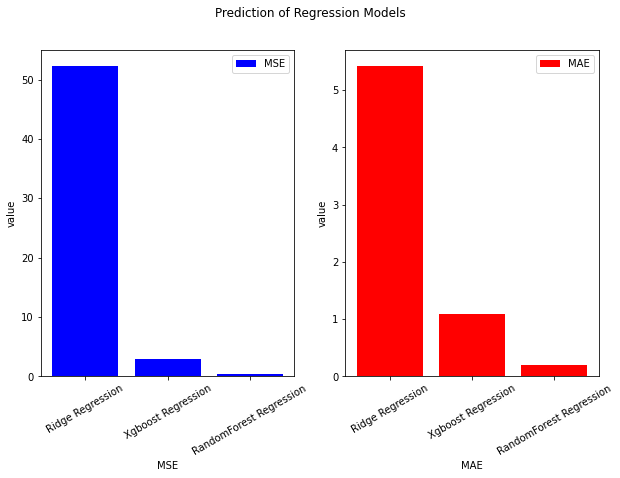

In [21]:
model_name = ['Ridge Regression', 'Xgboost Regression', 'RandomForest Regression']

fig, axes = plt.subplots(1, 2, figsize = (10, 6))
plt.suptitle('Prediction of Regression Models')
plt.setp(axes, xticks = range(3))
axes[0].bar(model_name, [mse_1, mse_2, mse_3], label = 'MSE', color = 'blue')
axes[0].legend()
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('value')
axes[0].set_xticklabels(model_name, rotation = 30)
axes[1].bar(model_name, [mae_1, mae_2, mae_3], label = 'MAE', color = 'red')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('value')
axes[1].legend()
axes[1].set_xticklabels(model_name, rotation = 30)

# 特徵重要度

##### 已預先計算特徵重要度

In [16]:
##### built-in importance #####
importance_df = pd.DataFrame(index = colnames)
glm = np.abs(clf_1.coef_)
importance_df['GLM_coef'] = glm
xgb_gain = clf_2.feature_importances_
importance_df['XGB_gain'] = xgb_gain
rf_gain = clf_3.feature_importances_
importance_df['RF_gain'] = rf_gain

##### permutation importance #####
ridge_permu = permutation_importance(clf_1, test_x, test_y, n_repeats = 3)
ridge_mean = ridge_permu['importances_mean']
ridge_std = ridge_permu['importances_std']
importance_df['Ridge_permutation'] = ridge_mean
xgb_permu = permutation_importance(clf_2, test_x, test_y, n_repeats = 3)
xgb_mean = xgb_permu['importances_mean']
xgb_std = xgb_permu['importances_std']
importance_df['XGB_permutation'] = xgb_mean
rf_permu = permutation_importance(clf_3, test_x, test_y, n_repeats = 3)
rf_mean = rf_permu['importances_mean']
rf_std = rf_permu['importances_std']
importance_df['RF_permutation'] = rf_mean

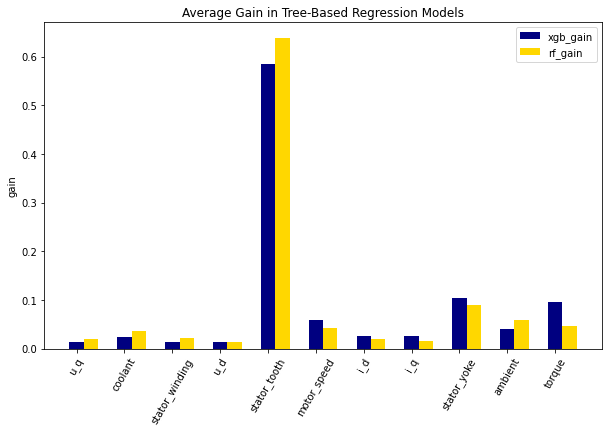

In [22]:
fig = plt.figure(figsize = (10, 6))
width = 0.3
plt.bar(range(len(colnames)), importance_df['XGB_gain'], width, label = 'xgb_gain', color = 'navy')
plt.bar(np.array(range(len(colnames)))+width, importance_df['RF_gain'], width, label = 'rf_gain', color = 'gold')
plt.xticks(ticks = range(len(colnames)), labels = colnames, rotation = 60)
plt.ylabel('gain')
plt.title('Average Gain in Tree-Based Regression Models')
plt.legend()

<ErrorbarContainer object of 3 artists>

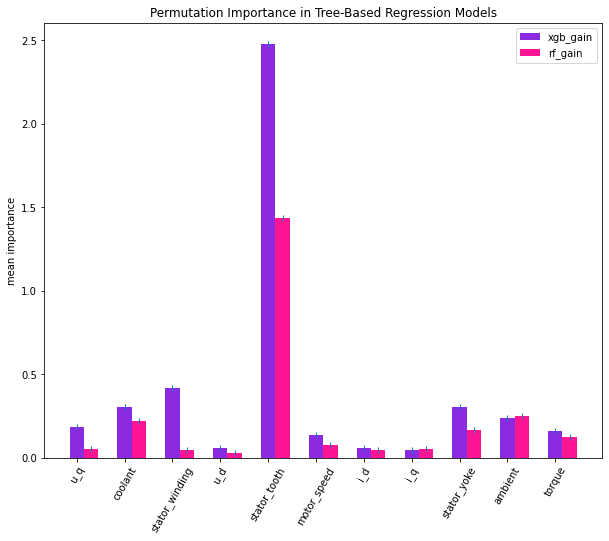

In [23]:
fig = plt.figure(figsize = (10, 8))
width = 0.3
plt.bar(np.array(range(len(colnames))), importance_df['XGB_permutation'], width, label = 'xgb_gain', color = 'blueviolet')
plt.bar(np.array(range(len(colnames)))+width, importance_df['RF_permutation'], width, label = 'rf_gain', color = 'deeppink')
plt.xticks(ticks = range(len(colnames)), labels = colnames, rotation = 60)
plt.ylabel('mean importance')
plt.title('Permutation Importance in Tree-Based Regression Models')
plt.legend()
plt.errorbar(np.array(range(len(colnames))), importance_df['XGB_permutation'], yerr = xgb_std, fmt = '|', ecolor = 'black', elinewidth = 1)
plt.errorbar(np.array(range(len(colnames)))+width, importance_df['RF_permutation'], yerr = rf_std, fmt = '|', ecolor = 'black')

In [24]:
rank_df = importance_df.rank(ascending = False)
sum_rank = pd.Series(rank_df.apply(sum, axis = 1))
rank_df['Total Rank'] = sum_rank.rank()
rank_df = rank_df.sort_values('Total Rank')
rank_df

,GLM_coef,XGB_gain,RF_gain,Ridge_permutation,XGB_permutation,RF_permutation,Total Rank
stator_tooth,1.0,1.0,1.0,1.0,1.0,1.0,1.0
stator_yoke,3.0,2.0,2.0,3.0,3.0,4.0,2.0
ambient,7.0,5.0,3.0,7.0,5.0,2.0,3.0
stator_winding,2.0,10.0,7.0,2.0,2.0,9.0,4.0
coolant,6.0,8.0,6.0,6.0,4.0,3.0,5.5
motor_speed,5.0,4.0,5.0,5.0,8.0,6.0,5.5
u_q,4.0,9.0,9.0,4.0,6.0,7.0,7.0
torque,11.0,3.0,4.0,11.0,7.0,5.0,8.0
i_d,8.0,7.0,8.0,8.0,10.0,10.0,9.0
i_q,10.0,6.0,10.0,10.0,11.0,8.0,10.0


#使用TOP5重要之變數預測

In [25]:
columnsKeep5 = ['profile_id', 'pm', 'coolant', 'torque', 'u_q', 'i_d', 'i_q', 'u_d']
# columnsKeep3 = columnsKeep5 + ['ambient', 'motor_speed']
# columnsNoStator = ['profile_id', 'stator_tooth', 'stator_yoke', 'stator_winding', 'torque', 'motor_speed', 'pm']


X_5 = dataset.copy().drop(columns = columnsKeep5)
y_5 = dataset.pm
colnames = X_5.columns
train_x_5, test_x_5, train_y_5, test_y_5 = train_test_split(X_5, y_5, test_size = 0.6)

scaler = StandardScaler()
train_x_5 = scaler.fit_transform(train_x_5)
test_x_5 = scaler.transform(test_x_5)
train_x_5 = pd.DataFrame(train_x_5, columns = colnames)
test_x_5 = pd.DataFrame(test_x_5, columns = colnames)

##### 已預先訓練模型

In [8]:
def regression_5(train_x, train_y, test_x, test_y, model, config):
  if model == 'ridge':
    config = {
        'alpha': 0.01
    }
    clf = Ridge(**config)
  elif model == 'randomforest':
    config = {
        'n_estimators': 100
    }
    clf = RandomForestRegressor(**config)
  elif model == 'xgboost':
    config = {
        'learning_rate': 0.7,
        'max_depth': 8,
        'subsample': 0.75,
        'alpha': 0.1
    }
    clf = XGBRegressor(**config)

  clf.fit(train_x_5, train_y_5) 
  predict_y_5 = clf.predict(test_x_5)
  MSE = np.mean(np.square(predict_y_5 - test_y_5))
  MAE = np.mean(np.abs(predict_y_5 - test_y_5))
  print('Regression Model: ', model, ' regession', '\nMSE = ', MSE, '\nMAE = ' , MAE, '\n')
  return clf, MSE, MAE


clf_4, mse_4, mae_4 = regression_5(train_x_5, train_y_5, test_x_5, test_y_5, model = 'ridge', config = {})
clf_5, mse_5, mae_5 = regression_5(train_x_5, train_y_5, test_x_5, test_y_5, model = 'xgboost', config = {})
clf_6, mse_6, mae_6 = regression_5(train_x_5, train_y_5, test_x_5, test_y_5, model = 'randomforest', config = {})

Regression Model:  ridge  regession 
MSE =  62.62177977269237 
MAE =  5.987819592972345 

[03:14:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Regression Model:  xgboost  regession 
MSE =  6.884528968153128 
MAE =  1.6001141687664562 

Regression Model:  randomforest  regession 
MSE =  1.11471090868684 
MAE =  0.3622429673739547 



[Text(0, 0, 'Ridge Regression'),
 Text(0, 0, 'Xgboost Regression'),
 Text(0, 0, 'RandomForest Regression')]

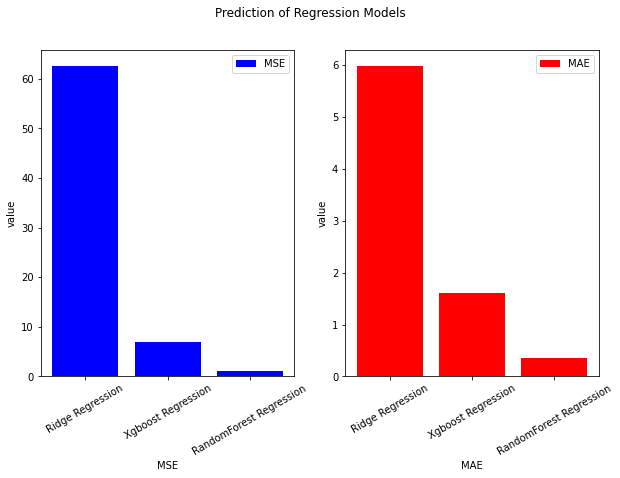

In [26]:
model_name = ['Ridge Regression', 'Xgboost Regression', 'RandomForest Regression']

fig, axes = plt.subplots(1, 2, figsize = (10, 6))
plt.suptitle('Prediction of Regression Models')
plt.setp(axes, xticks = range(3))
axes[0].bar(model_name, [mse_4, mse_5, mse_6], label = 'MSE', color = 'blue')
axes[0].legend()
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('value')
axes[0].set_xticklabels(model_name, rotation = 30)
axes[1].bar(model_name, [mae_4, mae_5, mae_6], label = 'MAE', color = 'red')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('value')
axes[1].legend()
axes[1].set_xticklabels(model_name, rotation = 30)